# Simplicity in unsupervised categorisation

In [1]:
import numpy as np
from math import factorial, comb, inf, log2, ceil, pow
import matplotlib.pyplot as plt

### Implementing the formalisation

In [2]:
def compute_pairwise_distances(points:list[list[int]]) -> np.array:
    points_matrix = np.repeat(points, len(points), axis=0).reshape(len(points),len(points),2)
    points_matrix_T = np.concatenate([points]*len(points), axis=0).reshape(len(points),len(points),2)
  
    return np.linalg.norm(points_matrix_T-points_matrix, axis=2)

def compute_constraints(categories:list[list[int]]) -> int:
    inside_dists = 0
    for c in categories:
        inside_dists += (len(c)*(len(c)-1))/2

    ouside_dists = 0
    for i in range(len(categories)-1):
        for j in range(i+1, len(categories)):
            ouside_dists += len(categories[i])*len(categories[j])

    return inside_dists * ouside_dists

def compute_categorisation_costs(points:list[list[int]], categories:list[list[int]]) -> int: 
    r = len(points)
    n = len(categories)
    part_r_n = sum((pow(-1, v)) * (pow(n-v, r)) / (factorial(n-v)*factorial(v)) for v in range(n))  # Stirling number of 2nd kind
    
    return ceil(log2(len(categories)+1)) + ceil(log2(part_r_n))

def compute_number_of_errors(points, categories):
    error_counter = 0
    distance_matrix = compute_pairwise_distances(points)

    ij_in_same_category = False
    kl_in_same_category = False

    # iterate over top right part of distance matrix, current points are (i,j)
    for i in range(0, distance_matrix.shape[0]):
        for j in range(i+1, distance_matrix.shape[1]):
            # d(i,j) is the fist distance

        # check if i and j are in the same or in different categories
            for c in categories:  
                if (i in c) and not(j in c) or not(i in c) and (j in c): # i and j in different categories
                    ij_in_same_category = False
                    break  
                if i in c and j in c: ij_in_same_category = True

    # iterate over points right or bottom from (i,j), current points are (k,l)
            for k in range(i, distance_matrix.shape[0]):
                for l in range(k+1, distance_matrix.shape[1]):
                    # d(k,l) is the second distance we might want to compare to d(i,j) 

                    if k>i or l>j:  # ignore redundand comparisons

        # check if k and l are in the same or in different categories
                        for c in categories:  
                            if (k in c) and not(l in c) or not(k in c) and (l in c): # k and l in different categories
                                kl_in_same_category = False
                                break  
                            if k in c and l in c: kl_in_same_category = True

    # check for possible error
                        if ij_in_same_category + kl_in_same_category == 1:  # actual constraint, possible error
                            if ij_in_same_category and (distance_matrix[i,j] > distance_matrix[k,l]): error_counter += 1
                            if kl_in_same_category and (distance_matrix[k,l] > distance_matrix[i,j]): error_counter += 1

    return error_counter

def compute_number_of_errors_equality(points, categories):
    error_counter = 0
    distance_matrix = compute_pairwise_distances(points)

    ij_in_same_category = False
    kl_in_same_category = False

    # iterate over top right part of distance matrix, current points are (i,j)
    for i in range(0, distance_matrix.shape[0]):
        for j in range(i+1, distance_matrix.shape[1]):
            # d(i,j) is the fist distance

        # check if i and j are in the same or in different categories
            for c in categories:  
                if (i in c) and not(j in c) or not(i in c) and (j in c): # i and j in different categories
                    ij_in_same_category = False
                    break  
                if i in c and j in c: ij_in_same_category = True

    # iterate over points right or bottom from (i,j), current points are (k,l)
            for k in range(i, distance_matrix.shape[0]):
                for l in range(k+1, distance_matrix.shape[1]):
                    # d(k,l) is the second distance we might want to compare to d(i,j) 

                    if k>i or l>j:  # ignore redundand comparisons

        # check if k and l are in the same or in different categories
                        for c in categories:  
                            if (k in c) and not(l in c) or not(k in c) and (l in c): # k and l in different categories
                                kl_in_same_category = False
                                break  
                            if k in c and l in c: kl_in_same_category = True

    # check for possible error
                        if ij_in_same_category + kl_in_same_category == 1:  # actual constraint, possible error
                            if ij_in_same_category and (distance_matrix[i,j] >= distance_matrix[k,l]): error_counter += 1
                            if kl_in_same_category and (distance_matrix[k,l] >= distance_matrix[i,j]): error_counter += 1

    return error_counter

def compute_error_costs(constraints:int, errors:int) -> int:
    # if errors > constraints:
    #     raise Exception("MORE ERRORS THAN CONSTRAINTS!!!")
    
    if errors >= constraints/2: return inf
    else: 
        try:
            result = ceil(log2(errors+1)) + ceil(log2(comb(int(constraints), int(errors))))    # num of errors may not be greater than num of than constraints
        except: 
            print(constraints)
            print(errors)

    return result

def compute_codelength_chater_pothos(points:list[list[int]], categories:list[list[int]], do_print:bool=False) -> tuple[int,int,int,int,int]:
    r = points.shape[0] # number of points
    s = (r*(r-1))/2 # number of distances
    inequalities = (s*(s-1))/2  # number of inequalities

    constraints = compute_constraints(categories)    # number of contraints

    categorisation_costs = compute_categorisation_costs(points, categories)  # costs to store the categorisation

    number_of_errors = compute_number_of_errors(points, categories)

    error_correction_costs = compute_error_costs(constraints, number_of_errors)

    if error_correction_costs == inf: codelength = inf
    else: codelength = inequalities - constraints + categorisation_costs + error_correction_costs
    if do_print: print(f"The total encoding of the categorisation {categories} is of length {codelength}.\n  This is the result of a compression of {inequalities - codelength} computed as {constraints} bits for constraints - {categorisation_costs} bits for categories - {error_correction_costs} bits for error correction.")
    return codelength, inequalities, constraints, categorisation_costs, error_correction_costs


def compute_codelength_equality(points:list[list[int]], categories:list[list[int]], do_print:bool=False) -> tuple[int,int,int,int,int]:
    r = points.shape[0] # number of points
    s = (r*(r-1))/2 # number of distances
    inequalities = (s*(s-1))/2  # number of inequalities
    inequalities_bits = inequalities * 2  # two bits to represent three states (less, equal, greater)

    constraints = compute_constraints(categories)    # number of contraints
    constraints_bits = constraints * 2

    categorisation_costs = compute_categorisation_costs(points, categories)  # costs to store the categorisation

    number_of_errors = compute_number_of_errors_equality(points, categories)

    error_correction_costs = compute_error_costs(constraints, number_of_errors)

    if error_correction_costs == inf: codelength = inf
    else: codelength = inequalities_bits - constraints_bits + categorisation_costs + error_correction_costs
    if do_print: print(f"The total encoding of the categorisation {categories} is of length {codelength}.\n  This is the result of a compression of {inequalities_bits - codelength} computed as {constraints} bits for constraints - {categorisation_costs} bits for categories - {error_correction_costs} bits for error correction.")
    return codelength, inequalities_bits, constraints_bits, categorisation_costs, error_correction_costs

def compute_codelength_weighted(points:list[list[int]], categories:list[list[int]], weight:float,  do_print:bool=False) -> tuple[int,int,int,int,int]:
    r = points.shape[0] # number of points
    s = (r*(r-1))/2 # number of distances
    inequalities = (s*(s-1))/2  # number of inequalities

    constraints = compute_constraints(categories)    # number of contraints

    categorisation_costs = compute_categorisation_costs(points, categories)  # costs to store the categorisation

    number_of_errors = compute_number_of_errors(points, categories)

    error_correction_costs = weight * compute_error_costs(constraints, number_of_errors)

    if error_correction_costs == inf: codelength = inf
    else: codelength = inequalities - constraints + categorisation_costs + error_correction_costs
    if do_print: print(f"The total encoding of the categorisation {categories} is of length {codelength}.\n  This is the result of a compression of {inequalities - codelength} computed as {constraints} bits for constraints - {categorisation_costs} bits for categories - {error_correction_costs} bits for error correction weighted by the factor {weight}.")
    return codelength, inequalities, constraints, categorisation_costs, error_correction_costs


### Searching all possible categorisations for the optimum

Method for partition from: https://stackoverflow.com/questions/19368375/set-partitions-in-python

In [3]:
def partition(collection):
    if len(collection) == 1:
        yield [ collection ]
        return

    first = collection[0]
    for smaller in partition(collection[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [ [ first ] ] + smaller


def compute_optimal_categorisations(points:list[list[int]], version:str='original', weight:float=1, do_print:bool=False) -> tuple[list[list[int], list[list[list[int]]]]]:
    min_codelength = inf
    optimal_categorisation = []
    all_optimal_categorisations = []

    for c in partition(list(range(0,len(points)))):
        if version == 'equal':
            codelength, _, _, _, _ = compute_codelength_equality(points, c)
        if version == 'original':
            codelength, _, _, _, _ = compute_codelength_chater_pothos(points, c)
        if version == 'weighted':
            codelength, _, _, _, _ = compute_codelength_weighted(points, c, weight)
        if codelength < min_codelength:
            min_codelength = codelength
            optimal_categorisation = c
            all_optimal_categorisations = [c]
        elif codelength == min_codelength: 
            all_optimal_categorisations.append(c)
    
    if do_print: 
        print(f"[{version}] An optimal categorisation is {optimal_categorisation}. There is/are {len(all_optimal_categorisations)} optimal one(s). The optimal codelength is {min_codelength}.")
        if version == 'equal':
            compute_codelength_equality(points, optimal_categorisation, True)
        if version == 'original':
            compute_codelength_chater_pothos(points, optimal_categorisation, True)
        if version == 'weighted':
            compute_codelength_weighted(points, optimal_categorisation, weight, True)
    return optimal_categorisation, all_optimal_categorisations


### Plotting

In [4]:
def plot_points_black(points):
    
    plt.figure(figsize=(5, 5), dpi=80)

    plt.scatter(x=points[:,0], y=points[:,1], color='black')
    ax = plt.gca()
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])

    plt.show()


def plot_categorisation(points, categories, version:str='original'):

    plt.figure(figsize=(5, 5), dpi=80)
    colors = plt.cm.jet(np.linspace(0, 1, len(categories)))

    for idx, category in enumerate(categories):
        category_points = points[category]
        plt.scatter(x=category_points[:, 0], 
                    y=category_points[:, 1], 
                    color=colors[idx], 
                    label=f'Category {idx + 1}')
    
    ax = plt.gca()
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
    ax.set_title(version)

    # plt.legend()
    plt.show()

def plot_all_optimal_categorisations(points, all_optimal_categorisations):
    for categorisation in all_optimal_categorisations:
        plot_categorisation(points, categorisation)

In [5]:
def do_the_thing(points:list[list[int]]) :
    opt_original, _ = compute_optimal_categorisations(points, 'original',True)
    opt_equal, _ = compute_optimal_categorisations(points, 'equal',True)
    weight_a = 1.5
    opt_weighted_a, _ = compute_optimal_categorisations(points, 'weighted', weight_a, True)
    weight_b = 0.5
    opt_weighted_b, _ = compute_optimal_categorisations(points, 'weighted', weight_b, True)

    plot_categorisation(points, opt_original, 'original')
    plot_categorisation(points, opt_equal, 'including equal')
    plot_categorisation(points, opt_weighted_a, f'weighted by {weight_a}')
    plot_categorisation(points, opt_weighted_b, f'weighted by {weight_b}')


## Example

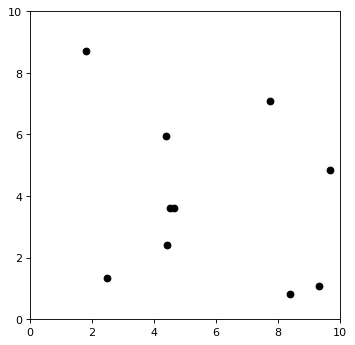

In [13]:
points_example = np.array([[0.83720151, 0.08250322],
                    [0.442193 ,  0.24037118],
                    [0.24870598, 0.13469951],
                    [0.18027245, 0.87028613],
                    [0.96628945, 0.4852758 ],
                    [0.45288128, 0.36227845],
                    [0.93201882, 0.10808033],
                    [0.43761015, 0.59503974],
                    [0.77300843, 0.7072553 ],
                    [0.46410716, 0.3618821 ]])*10 # np.random.rand(10,2) #+ np.repeat([0,3],10).reshape(10,2)
plot_points_black(points_example)


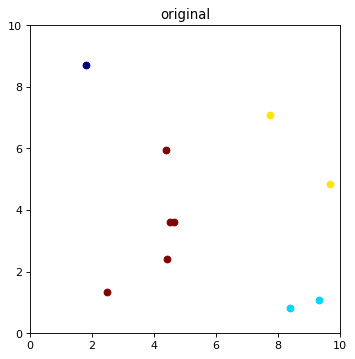

In [8]:
opt, _ = compute_optimal_categorisations(points_example,'original', True)

plot_categorisation(points_example, opt)

# Data from the paper

### 1) Two clusters

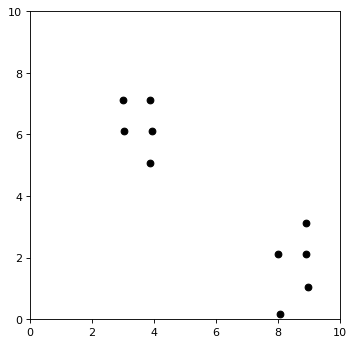

In [14]:
points_1 = np.array([3, 7.13, 3.88, 7.13, 3.02, 6.11, 3.93, 6.11, 3.88, 5.06, 8.91, 3.11, 8.01, 2.13, 8.9, 2.13, 8.98, 1.04, 8.05, 0.18]).reshape(10,2)
plot_points_black(points_1)

In [15]:
# opt_1, _ = compute_optimal_categorisations(points_1, True)

# plot_categorisation(points_1, opt_1)

In [16]:
# compute_codelength(points_1, opt_1, True)

### 2) Big, small cluster

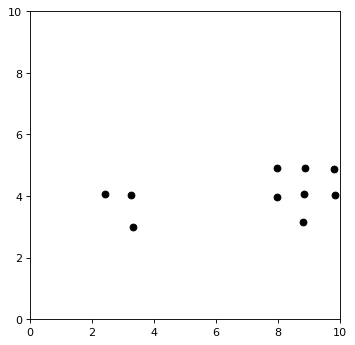

In [17]:
points_2 = np.array([2.42, 4.05, 3.25, 4.02, 3.32, 3.01, 7.96, 4.9, 8.87, 4.9, 9.8, 4.87, 7.97, 3.97, 8.84, 4.07, 9.84, 4.02, 8.81, 3.16]).reshape(10,2)
plot_points_black(points_2)

In [18]:
# opt_2, _ = compute_optimal_categorisations(points_2, True)

# plot_categorisation(points_2, opt_2)

In [19]:
# compute_codelength(points_2, opt_2, True)

### 3) Three clusters

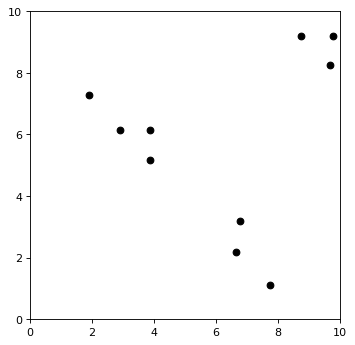

In [20]:
points_3 = np.array([1.91, 7.27, 2.91, 6.15, 3.88, 6.15, 3.88, 5.16, 8.74, 9.2, 9.78, 9.18, 9.69, 8.26, 6.78, 3.18, 6.66, 2.18, 7.75, 1.12]).reshape(10,2)
plot_points_black(points_3)

In [21]:
# opt_3, _ = compute_optimal_categorisations(points_3, True)

# plot_categorisation(points_3, opt_3)

In [22]:
# compute_codelength(points_3, opt_3, True)

### 4) Little structure

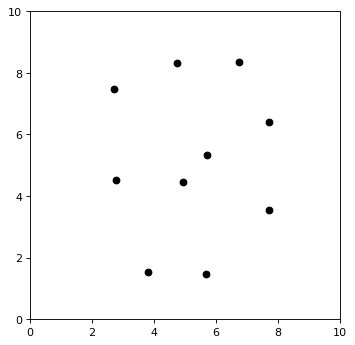

In [23]:
points_4 = np.array([2.7, 7.48, 4.75, 8.32, 6.73, 8.36, 2.77, 4.53, 4.92, 4.45, 5.72, 5.33, 7.72, 6.41, 7.7, 3.53, 3.82, 1.52, 5.69, 1.48]).reshape(10,2)
plot_points_black(points_4)

[weighted] An optimal categorisation is [[0], [1, 2], [3], [4, 5], [6], [7], [8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 880.0.
The total encoding of the categorisation [[0], [1, 2], [3], [4, 5], [6], [7], [8, 9]] is of length 880.0.
  This is the result of a compression of 110.0 computed as 126.0 bits for constraints - 16 bits for categories - 0 bits for error correction weighted by the factor 2.
[weighted] An optimal categorisation is [[0, 1, 2, 6], [3, 4, 5, 7, 8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 672.5.
The total encoding of the categorisation [[0, 1, 2, 6], [3, 4, 5, 7, 8, 9]] is of length 672.5.
  This is the result of a compression of 317.5 computed as 504.0 bits for constraints - 11 bits for categories - 175.5 bits for error correction weighted by the factor 0.5.


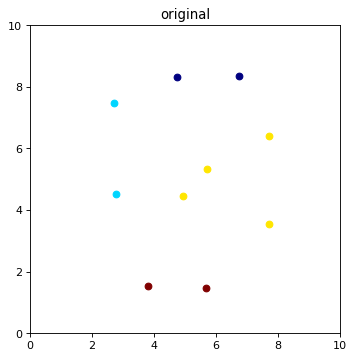

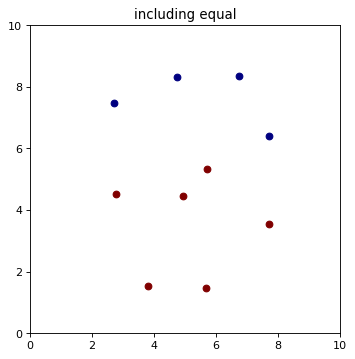

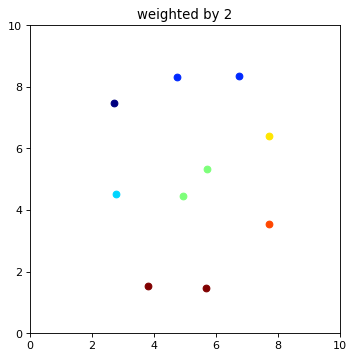

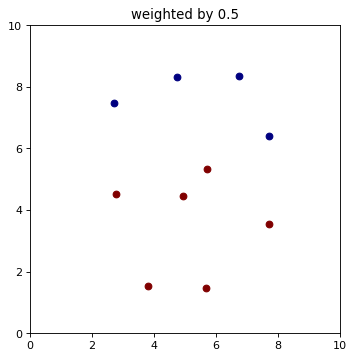

In [24]:
do_the_thing(points_4)

In [ ]:
compute_codelength(points_4, opt_4, True)

[weighted] An optimal categorisation is [[0, 1], [3, 4, 5], [2, 6], [7], [8, 9]]. There is/are 1 optimal one(s). The optimal codelength is 854.3.
The total encoding of the categorisation [[0, 1], [3, 4, 5], [2, 6], [7], [8, 9]] is of length 854.3.
  This is the result of a compression of 135.70000000000005 computed as 234.0 bits for constraints - 19 bits for categories - 79.3 bits for error correction weighted by the factor 1.3.


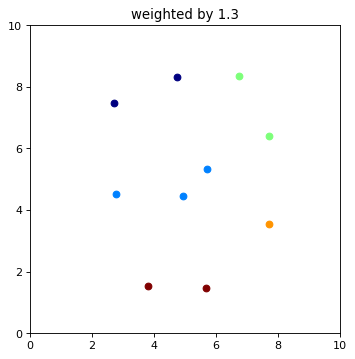

[[8.30930878 0.11226634]
 [3.31339091 4.45146947]
 [4.97282451 4.92725818]
 [7.6153998  7.49988126]
 [2.90479672 6.61424088]
 [1.09097799 0.90068599]
 [0.70472829 1.18627432]
 [1.98544094 1.00260936]
 [7.52458795 1.67270019]
 [5.6493741  6.21357853]]


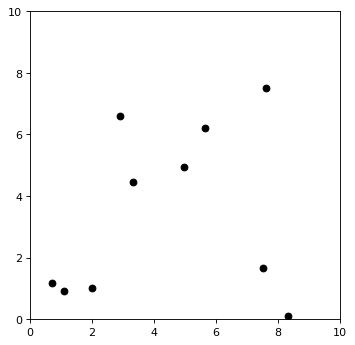

[[6.65413005 0.6334262 ]
 [5.14025148 9.21720115]
 [3.01844189 1.52713563]
 [0.57371172 2.96151463]
 [5.11019625 2.49292232]
 [7.3939303  8.50027079]
 [8.15200886 9.26539904]
 [6.33052207 6.10050806]
 [5.36762435 2.6799413 ]
 [0.16207719 0.47377474]]


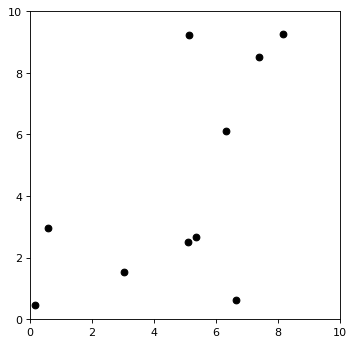

In [36]:
random_points = np.random.rand(10,2)*10
print(random_points)
plot_points_black(random_points)

In [ ]:
points = np.array([[6.65413005, 0.6334262 ],[5.14025148, 9.21720115],[3.01844189, 1.52713563],[0.57371172, 2.96151463],[5.11019625, 2.49292232],[7.3939303,  8.50027079],[8.15200886, 9.26539904],[6.33052207, 6.10050806], [5.36762435, 2.6799413 ], [0.16207719, 0.47377474]])

do_the_thing(points)